<a href="https://colab.research.google.com/github/simsekergun/RingDimensionDS/blob/main/SM_Prediction_vs_N_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

In [2]:
XY_train1 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtrainingDint1SM1_50.csv', header=None)
XY_train1['SM'] = 1
XY_test1 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtestDint1SM1_50.csv', header=None)
XY_test1['SM'] = 1
XY_train2 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtrainingDint1SM2_50.csv', header=None)
XY_train2['SM'] = 2
XY_test2 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtestDint1SM2_50.csv', header=None)
XY_test2['SM'] = 2
XY_train3 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtrainingDint1SM3_50.csv', header=None)
XY_train3['SM'] = 3
XY_test3 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtestDint1SM3_50.csv', header=None)
XY_test3['SM'] = 3
XY_train4 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtrainingDint1SM4_50.csv', header=None)
XY_train4['SM'] = 4
XY_test4 = pd.read_csv('https://raw.githubusercontent.com/simsekergun/RingDimensionDS/refs/heads/main/datasets/SiNtestDint1SM4_50.csv', header=None)
XY_test4['SM'] = 4

In [3]:
# Merge all training datasets vertically
XY_train_combined = pd.concat([XY_train1, XY_train2, XY_train3, XY_train4], axis=0)
# Reset index
XY_train_combined.reset_index(drop=True, inplace=True)
# Verify the shape
print(f"Combined dataset shape: {XY_train_combined.shape}")  # Should be (1764, 173)

Combined dataset shape: (1764, 174)


In [4]:
# Merge all test datasets vertically
XY_test_combined = pd.concat([XY_test1, XY_test2, XY_test3, XY_test4], axis=0)

# Reset index
XY_test_combined.reset_index(drop=True, inplace=True)

# Verify the shape
print(f"Combined test dataset shape: {XY_test_combined.shape}")

Combined test dataset shape: (176, 174)


In [5]:
xmax = 40000.0


X_train = XY_train_combined.iloc[:,np.arange(2,173)].copy()
X_test = XY_test_combined.iloc[:,np.arange(2,173)].copy()
X_train = X_train/xmax
X_test = X_test/xmax

Y_train = XY_train_combined.iloc[:,173]
Y_test = XY_test_combined.iloc[:,173]

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 1. Prepare the data
print("Original shapes:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

# Convert labels to one-hot encoding (since we have 4 classes)
Y_train_onehot = to_categorical(Y_train - 1, num_classes=4)  # Convert 1-4 to 0-3
Y_test_onehot = to_categorical(Y_test - 1, num_classes=4)

# Layer size calculations
N = 171
N1 = int(2 ** np.ceil(np.log2(N)))   # e.g., 256
N2 = int(N1 / 2)                     # e.g., 128
N3 = int(N1 / 4)                     # e.g., 64

# Build the neural network
model = Sequential([
    Dense(N2, activation='relu', input_shape=(N,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(N3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(X_train, Y_train_onehot,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test, Y_test_onehot),
                    callbacks=[reduce_lr, early_stop],
                    verbose=0)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test_onehot, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f}")


# 6. Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) + 1  # Convert back to 1-4 labels

# Print some examples
print("\nSample predictions:")
for i in range(10):
    print(f"True: {Y_test.iloc[i]}, Predicted: {y_pred_classes[i]}, Probabilities: {np.round(y_pred[i], 2)}")

Original shapes:
X_train: (1764, 171), Y_train: (1764,)
X_test: (176, 171), Y_test: (176,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 99.

Test accuracy: 1.0000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Sample predictions:
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]
True: 1, Predicted: 1, Probabilities: [1. 0. 0. 0.]


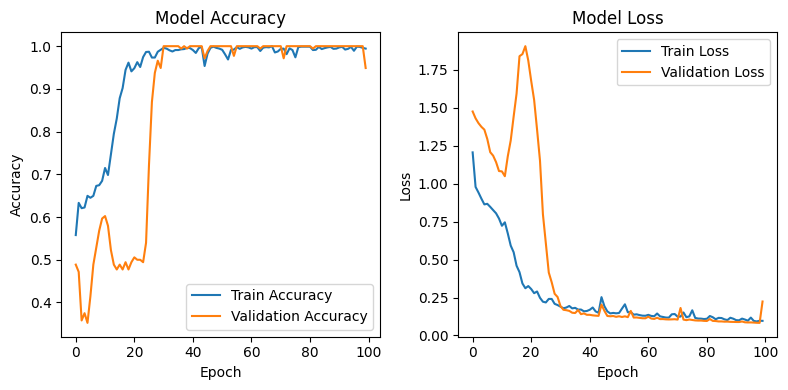


Model Performance Summary:
+------------+-----------+------------+
| Dataset    |   Samples |   Accuracy |
+============+===========+============+
| Training   |      1764 |     0.9943 |
+------------+-----------+------------+
| Validation |       176 |     0.9489 |
+------------+-----------+------------+

Class-wise Performance Metrics:
+---------+-------------+----------+------------+-----------+
| Class   |   Precision |   Recall |   F1-Score |   Samples |
+=========+=============+==========+============+===========+
| Model 1 |      1.0000 |   1.0000 |     1.0000 |   44.0000 |
+---------+-------------+----------+------------+-----------+
| Model 2 |      1.0000 |   1.0000 |     1.0000 |   44.0000 |
+---------+-------------+----------+------------+-----------+
| Model 3 |      1.0000 |   1.0000 |     1.0000 |   44.0000 |
+---------+-------------+----------+------------+-----------+
| Model 4 |      1.0000 |   1.0000 |     1.0000 |   44.0000 |
+---------+-------------+----------+---

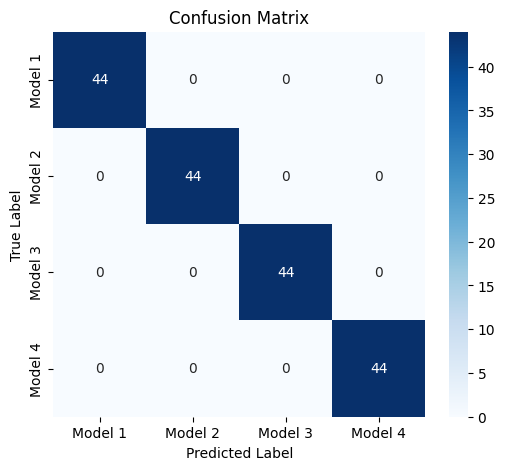

In [7]:
# Plot training history
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Performance table
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# Get class-wise accuracy
from sklearn.metrics import classification_report
y_test_true = Y_test.values
report = classification_report(y_test_true, y_pred_classes, output_dict=True, target_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'])

# Create table data
table_data = [
    ["Dataset", "Samples", "Accuracy"],
    ["Training", len(X_train), f"{final_train_acc:.4f}"],
    ["Validation", len(X_test), f"{final_val_acc:.4f}"]
]

# Print formatted table
print("\nModel Performance Summary:")
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

# Class-wise accuracy table
class_table = []
for i in range(4):
    class_table.append([
        f"Model {i+1}",
        report[f"Model {i+1}"]["precision"],
        report[f"Model {i+1}"]["recall"],
        report[f"Model {i+1}"]["f1-score"],
        report[f"Model {i+1}"]["support"]
    ])

print("\nClass-wise Performance Metrics:")
print(tabulate(class_table,
               headers=["Class", "Precision", "Recall", "F1-Score", "Samples"],
               tablefmt="grid",
               floatfmt=".4f"))

# Confusion matrix visualization

cm = confusion_matrix(y_test_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
            yticklabels=['Model 1', 'Model 2', 'Model 3', 'Model 4'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [8]:
from tensorflow.keras.regularizers import l2 as l2_reg

def get_N_vs_errors(ind):
  N = len(ind)
  N1 = int(2**np.ceil(np.log2(N)))
  N2 = int(N1/2)
  N3 = int(N1/4)

  # Build the neural network
  model = Sequential([
      Dense(N2, activation='relu', input_shape=(N,), kernel_regularizer=l2_reg(0.001)),
      BatchNormalization(),
      Dropout(0.2),

      Dense(N3, activation='relu', kernel_regularizer=l2_reg(0.001)),
      BatchNormalization(),
      Dropout(0.1),

      Dense(4, activation='softmax')  # 4 output classes
  ])

  # Compile the model with Adam optimizer
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # Callbacks
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
  early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

  # Train the model
  history = model.fit(X_train.iloc[:,ind], Y_train_onehot,
                      epochs=100,
                      batch_size=64,
                      validation_data=(X_test.iloc[:,ind], Y_test_onehot),
                      callbacks=[reduce_lr, early_stop],
                      verbose=0)

  # 6. Make predictions
  y_pred = model.predict(X_test.iloc[:,ind])
  y_pred_classes = np.argmax(y_pred, axis=1) + 1  # Convert back to 1-4 labels

  diff = np.abs(Y_test-y_pred_classes)
  no_of_errors = np.sum(diff > 0)
  return no_of_errors

In [9]:
no_trials = 20
no_regions = 3
Nmax = 171

# Dint_sample_range = np.arange(3, round((Nmax-2)/no_regions) + 1)
Dint_sample_range = np.array([5, 10, 15, 20, 25, 30, 40, 50])
error_val = np.zeros((len(Dint_sample_range), no_trials))

no_of_errors = np.zeros((len(Dint_sample_range),no_trials))

for irang in range(len(Dint_sample_range)):
    no_samples = Dint_sample_range[irang]  # choose an odd number

    for itx in range(no_trials):
        Dintsample = Nmax - 2
        ind_rand_samples = np.array([], dtype=int)  # Ensure integer type

        for irx in range(1, no_regions + 1):
            nmax = int(np.floor(Dintsample/no_regions))

            l1 = nmax * (irx - 1) + round(no_samples/2)
            l2 = nmax * irx - round(no_samples/2)

            if l1 < l2:
                rand_center = np.random.randint(l1, l2 + 1)
            else:
                rand_center = np.random.randint(l2, l1 + 1)

            # Create integer range and ensure proper bounds
            start = int(rand_center - np.floor(no_samples/2))
            end = int(rand_center + np.floor(no_samples/2))
            samples = np.arange(start, end + 1)

            ind_rand_samples = np.concatenate((ind_rand_samples, samples))

        # Filter and convert to integers
        ind_rand_samples = ind_rand_samples[(ind_rand_samples <= Dintsample) &
                                           (ind_rand_samples >= 1)].astype(int)
        no_of_errors[irang, itx] = get_N_vs_errors(ind_rand_samples)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 69: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 74: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 59.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 60: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 45.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 75: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 80: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 65.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 81: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 86: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 91: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 76.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 88: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 93: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 87: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 100: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 95.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 43.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 81: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 89: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 98: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch: 93.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 56.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 91: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 96: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 86.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 51.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 74: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 59.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 65: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 76: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 81: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 86: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 71.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 69: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 54.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 77: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 82: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 87: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 72.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 63: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 48.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 64: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 49.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 72: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 57.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 70: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 75: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 75: early stopping
Restoring model weights from the end of the best epoch: 60.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 71: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 84: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 97: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch: 92.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 70: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 88: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 93: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 98: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 83.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 99: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 94.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 72: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 77: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 86: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 95: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 74: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 79: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 84: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 69.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 68: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 76: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 81: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 86: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 71.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 79: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 88: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 93: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 67: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 72: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 79: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 87: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 94: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 99: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Restoring model weights from the end of the best epoch: 93.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 66: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 71: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 76: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 61.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 75: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 80: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 85: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 70.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 52: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 37.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 77: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 84: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 89: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 95: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 94: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 99: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 89.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 64: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 69: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 74: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 59.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 64: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 77: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 95: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 100: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 86: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 91: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 96: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 81.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 59: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 69: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 77: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 89: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 94: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 99: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Restoring model weights from the end of the best epoch: 93.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 64: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 86: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 64: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 84: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 84: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 98: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch: 93.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 96.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 63: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 84: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 96: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 59: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 64: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 69: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 54.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 79: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 84: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 89: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 75.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 49: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 34.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 67: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 82: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 87: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 92: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 77.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 55: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 40.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 42.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 46: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 65: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 73: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 78: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 83: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 68.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 61: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 46.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 93: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 63: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 69: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 74: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 79: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 91: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 96: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Restoring model weights from the end of the best epoch: 96.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 52: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 57: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 62: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 47.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 47: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 32.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 96: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 96.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 83: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 98: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 93.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 90: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 85: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 90: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 96.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 96.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 86: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 96.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 86: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 90: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 82: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 87: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 77: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 21.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 62: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 97: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 89: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 95: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 100: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 90.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 83: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 67: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 99: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 94.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 98: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 93.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 84: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 85: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 100: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 95.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 74: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 83: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 90: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 96.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 84: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 97: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 100: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 95.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 97: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 88: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 96: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 97.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 83: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 99.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 78: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 100.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 98.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [10]:
from google.colab import files

In [11]:
df = pd.DataFrame(no_of_errors)
csv_file = 'SM_no_of_errors_50.csv'
df.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>